In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt







import sys
sys.path.append('..')
from utils.helpers import *
# FILEPATH: /home/bule/projects/MVTec_Visualizer/workspace/mvtec_WIDERESNET50_syntheticAnomalies.ipynb
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [2]:
FILENAME = 'MVTEC_WIDERESNET50_3thBlock_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

In [3]:
## loe paper
"""
Since the MVTEC training set contains
no anomalies, we contaminate it with artificial anomalies
that we create by adding zero-mean Gaussian noise to the
features of test set anomalies. We use a large variance for
the additive noise (equal to the empirical variance of the
anomalous features) to reduce information leakage from the
test set into the training set.
"""

'\nSince the MVTEC training set contains\nno anomalies, we contaminate it with artificial anomalies\nthat we create by adding zero-mean Gaussian noise to the\nfeatures of test set anomalies. We use a large variance for\nthe additive noise (equal to the empirical variance of the\nanomalous features) to reduce information leakage from the\ntest set into the training set.\n'

In [4]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'contamination', 'crack', 'faulty_imprint', 'pill_type'],
    'screw': ['manipulated_front', 'scratch_head', 'thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil'],
    'toothbrush': ['defective'],
    'transistor': ['bent', 'cut', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'fabric_border', 'split_teeth', 'squeezed_teeth']
}

combined_samples,labels,class_list= create_synset_for_class("zipper",df)

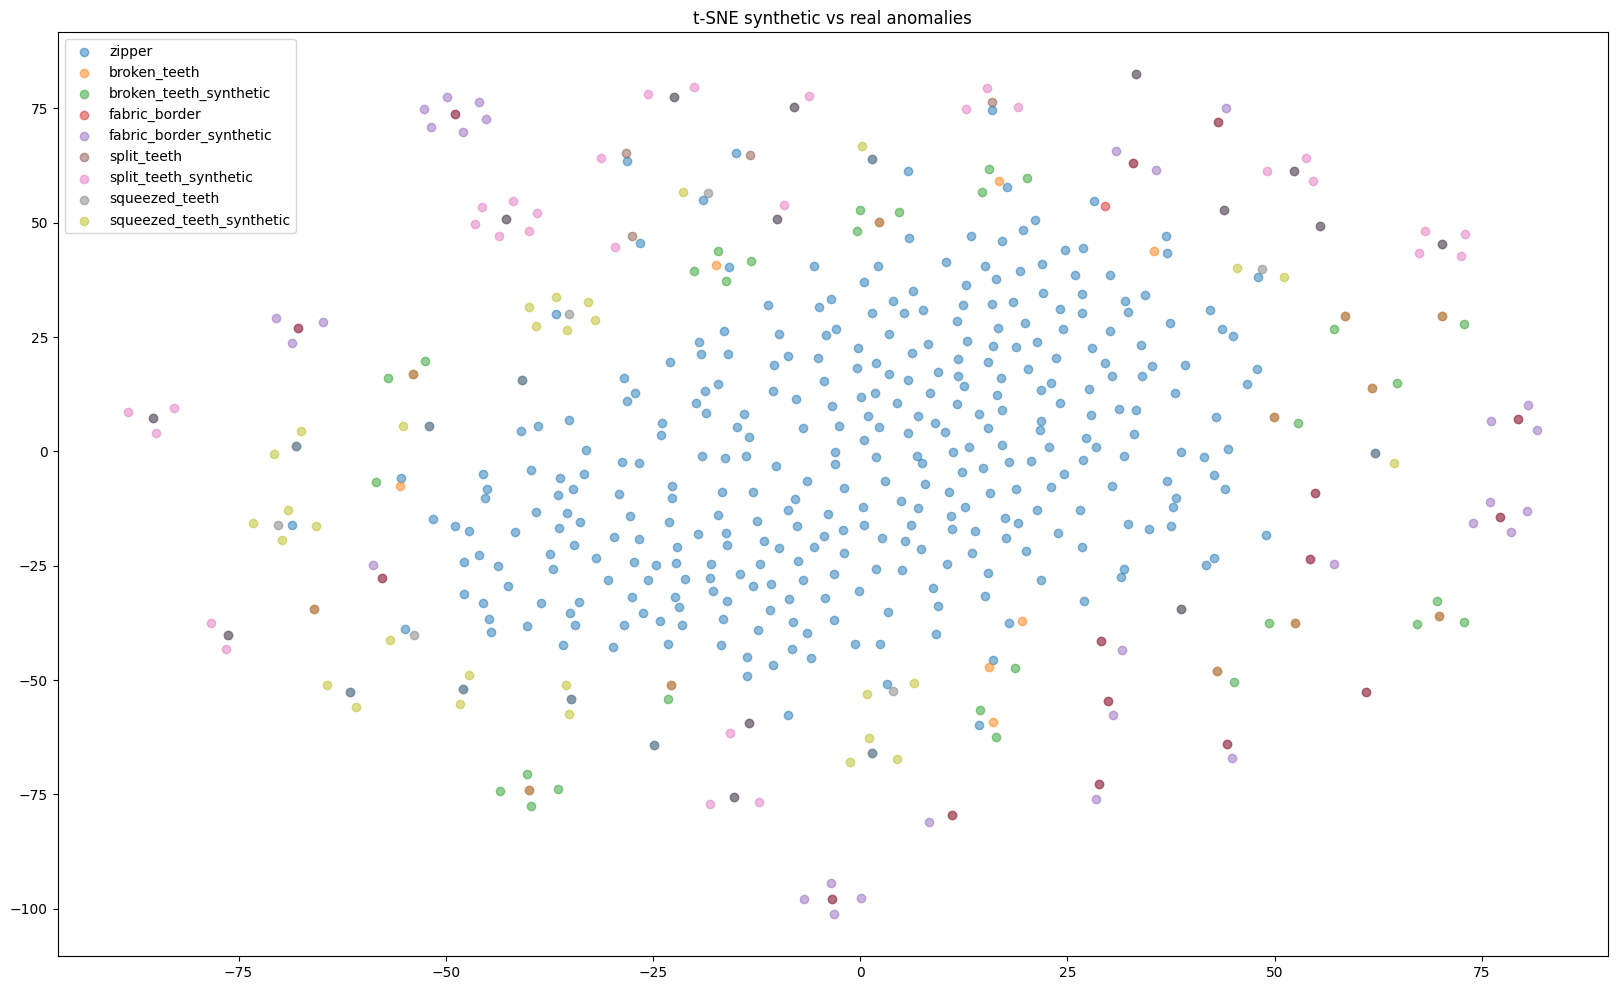

KeyboardInterrupt: 

In [5]:
for _ in range(5):

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)#, random_state=0
    reduced_data = tsne.fit_transform(combined_samples)

    # Plotting
    plt.figure(figsize=(20, 12))
    # Iterate over each unique label to plot them separately
    for i in range(len(class_list)):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5)

    plt.title('t-SNE synthetic vs real anomalies')
    plt.legend()
    plt.show()



In [ ]:
# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_samples)

# Plotting
plt.figure(figsize=(20, 12))
# Iterate over each unique label to plot them separately
for i in range(len(class_list)):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5)

plt.title('PCA')
plt.legend()
plt.show()


In [6]:
normals=combined_samples[labels==0]
anomalies=combined_samples[(labels % 2 != 0) & (labels != 0)] 
synthetic_anomalies=combined_samples[(labels % 2 == 0) & (labels != 0)] 
normals.shape

(391, 200704)

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np

# Assuming 'normals' is your input data
data = torch.tensor(normals)

# Splitting data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Creating TensorDatasets for training and validation sets
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)

# Creating DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)

class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(200704, 1000),  # Reducing dimension from 200704 to 1000
            nn.ReLU(),
            nn.Linear(1000, 500),     # Further reduction to 500
            nn.ReLU(),
            nn.Linear(500, 100)       # Code layer with 100 features
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(100, 500),      # Expanding from 100 to 500
            nn.ReLU(),
            nn.Linear(500, 1000),     # Expanding from 500 to 1000
            nn.ReLU(),
            nn.Linear(1000, 200704)   # Reconstructing the original 200704 features
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = SimpleAutoencoder().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

num_epochs = 50
patience = 5  # Early stopping patience
best_val_loss = np.inf
epochs_no_improve = 0
train_loss_log = []
val_loss_log = []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0

    for data in train_loader:
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_loss_log.append(train_loss)

    autoencoder.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs = data[0].to(device)
            outputs = autoencoder(inputs)
            loss = loss_function(outputs, inputs)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_loss_log.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    if epochs_no_improve == patience:
        print('Early stopping triggered!')
        break

# Save the model
#torch.save(autoencoder.state_dict(), 'autoencoder.pth')


Epoch [1/50], Train Loss: 75.5448, Validation Loss: 0.0203
Epoch [2/50], Train Loss: 0.1696, Validation Loss: 0.0168
Epoch [3/50], Train Loss: 0.0162, Validation Loss: 0.0154
Epoch [4/50], Train Loss: 0.0148, Validation Loss: 0.0140
Epoch [5/50], Train Loss: 0.0134, Validation Loss: 0.0128
Epoch [6/50], Train Loss: 0.0123, Validation Loss: 0.0117
Epoch [7/50], Train Loss: 0.0113, Validation Loss: 0.0108
Epoch [8/50], Train Loss: 0.0104, Validation Loss: 0.0100
Epoch [9/50], Train Loss: 0.0096, Validation Loss: 0.0093
Epoch [10/50], Train Loss: 0.0090, Validation Loss: 0.0087
Epoch [11/50], Train Loss: 0.0084, Validation Loss: 0.0082
Epoch [12/50], Train Loss: 0.0079, Validation Loss: 0.0077
Epoch [13/50], Train Loss: 0.0075, Validation Loss: 0.0073
Epoch [14/50], Train Loss: 0.0072, Validation Loss: 0.0070
Epoch [15/50], Train Loss: 0.0069, Validation Loss: 0.0068
Epoch [16/50], Train Loss: 0.0067, Validation Loss: 0.0066
Epoch [17/50], Train Loss: 0.0065, Validation Loss: 0.0064
Epoch

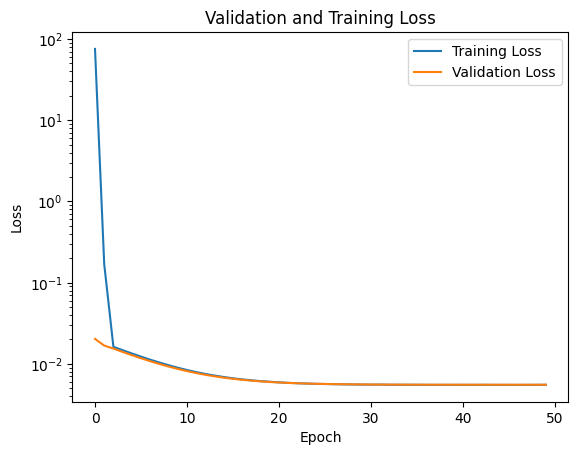

In [24]:
# Plotting the validation and training loss with logarithmic scale
plt.plot(train_loss_log, label='Training Loss')
plt.plot(val_loss_log, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation and Training Loss')
plt.legend()
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.show()


In [30]:
normalscores=F.mse_loss(autoencoder(torch.Tensor(normals).to(device)), torch.Tensor(normals).to(device))
anoscores=F.mse_loss(autoencoder(torch.Tensor(anomalies).to(device)), torch.Tensor(anomalies).to(device))
synanoscores=F.mse_loss(autoencoder(torch.Tensor(synthetic_anomalies).to(device)), torch.Tensor(synthetic_anomalies).to(device))



In [34]:


# Compute MSE scores
normal_scores = F.mse_loss(autoencoder(torch.Tensor(normals).to(device)), torch.Tensor(normals).to(device), reduction='none').mean(1)
anomaly_scores = F.mse_loss(autoencoder(torch.Tensor(anomalies).to(device)), torch.Tensor(anomalies).to(device), reduction='none').mean(1)
synthetic_anomaly_scores = F.mse_loss(autoencoder(torch.Tensor(synthetic_anomalies).to(device)), torch.Tensor(synthetic_anomalies).to(device), reduction='none').mean(1)
# Convert to CPU and to numpy array
normal_scores = normal_scores.cpu().detach().numpy()
anomaly_scores = anomaly_scores.cpu().detach().numpy()
synthetic_anomaly_scores = synthetic_anomaly_scores.cpu().detach().numpy()


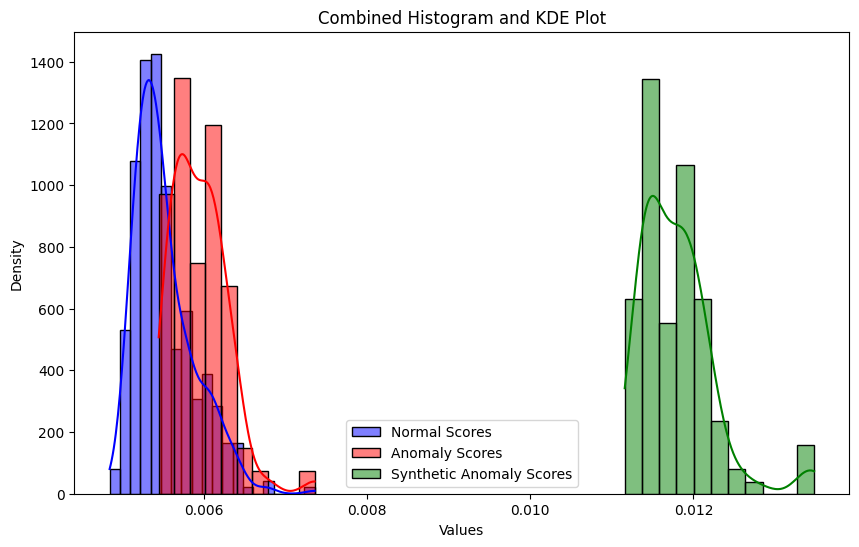

In [41]:
# Create the plot
plt.figure(figsize=(10, 6))  # You can adjust the size of the figure

# Plotting each distribution as a histogram and KDE
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5)
sns.histplot(anomaly_scores, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5)

# Additional formatting
plt.title('Combined Histogram and KDE Plot')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()  # Show the legend

# Display the plot
plt.show()


In [35]:
import seaborn as sns

# Plotting the distributions
sns.histplot(normalscores, kde=True, label='Normal Scores')
# sns.histplot(anoscores.cpu().detach().numpy(), kde=True, label='Anomaly Scores')
# sns.histplot(synanoscores.cpu().detach().numpy(), kde=True, label='Synthetic Anomaly Scores')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.legend()
plt.show()

TypeError: len() of a 0-d tensor